In [145]:
NOTEBOOK_NAME = "e016_ch_data_to_pupular_base"

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import seaborn as sns
import japanize_matplotlib
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error

In [ ]:
class Config:
    OUTPUT_DIR = f"../saved_data/{NOTEBOOK_NAME}"
    SEED = 33
    TARGET_COL = "reserve"


os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

In [ ]:
train_log = pd.read_csv("../data/train_log.csv")
train_label = pd.read_csv("../data/train_label.csv")

test_log = pd.read_csv("../data/test_log.csv")
test_session = pd.read_csv("../data/test_session.csv")

yado = pd.read_csv("../data/yado.csv")

sample_submission = pd.read_csv("../data/sample_submission.csv")

# # image_embeddings = pd.read_parquet("../data/image_embeddings.parquet")

In [ ]:
train = pd.read_pickle(
    f"../saved_data/e016_make_train_popular_base/e016_make_train_popular_base_merged_train.pkl"
)

test = pd.read_pickle(
    f"../saved_data/e016_make_train_popular_base/e016_make_train_popular_base_merged_test.pkl"
)

In [ ]:
# # debug
# train = train.sample(10000, random_state=Config.SEED).reset_index(drop=True)
# test = test.sample(10000, random_state=Config.SEED).reset_index(drop=True)

In [ ]:
# debug用
# train = train.sample(10000, random_state=SEED)

In [ ]:
# # ひとつ前のlogのyad_idの値を取得
# train["previous_1_yad_no"] = train["logged_yad_no_list"].apply(lambda x: x[-1])
# test["previous_1_yad_no"] = test["logged_yad_no_list"].apply(lambda x: x[-1])

# Sessionの情報を追加

In [ ]:
def add_session_length(
    train: pd.DataFrame,
    train_log: pd.DataFrame,
    test: pd.DataFrame,
    test_log: pd.DataFrame,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    sessionの長さを追加する
    """
    train_session_id_cnt_dict = (
        train_log.groupby("session_id")["yad_no"].count().to_dict()
    )
    test_session_id_cnt_dict = (
        test_log.groupby("session_id")["yad_no"].count().to_dict()
    )

    train["session_length"] = train["session_id"].map(train_session_id_cnt_dict)
    test["session_length"] = test["session_id"].map(test_session_id_cnt_dict)

    return train, test


train, test = add_session_length(train, train_log, test, test_log)

In [ ]:
def add_session_yado_nunique(
    train: pd.DataFrame,
    train_log: pd.DataFrame,
    test: pd.DataFrame,
    test_log: pd.DataFrame,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    sessionの中で登場したyadoの数を追加する
    """
    train_session_yado_cnt_dict = (
        train_log.groupby("session_id")["yad_no"].nunique().to_dict()
    )
    test_session_yado_cnt_dict = (
        test_log.groupby("session_id")["yad_no"].nunique().to_dict()
    )

    train["session_yado_nunique"] = train["session_id"].map(train_session_yado_cnt_dict)
    test["session_yado_nunique"] = test["session_id"].map(test_session_yado_cnt_dict)

    return train, test


train, test = add_session_yado_nunique(train, train_log, test, test_log)

In [ ]:
def add_session_yado_cnt(
    train: pd.DataFrame,
    train_log: pd.DataFrame,
    test: pd.DataFrame,
    test_log: pd.DataFrame,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    sessionとyadごとに、yad_noが登場した回数を数える
    """
    train_session_yado_cnt_dict = (
        train_log.groupby(["session_id", "yad_no"])["yad_no"].count().to_dict()
    )
    test_session_yado_cnt_dict = (
        test_log.groupby(["session_id", "yad_no"])["yad_no"].count().to_dict()
    )

    train["session_yado_cnt"] = train.apply(
        lambda x: train_session_yado_cnt_dict[(x["session_id"], x["yad_no"])]
        if (x["session_id"], x["yad_no"]) in train_session_yado_cnt_dict
        else 0,
        axis=1,
    )
    test["session_yado_cnt"] = test.apply(
        lambda x: test_session_yado_cnt_dict[(x["session_id"], x["yad_no"])]
        if (x["session_id"], x["yad_no"]) in test_session_yado_cnt_dict
        else 0,
        axis=1,
    )

    return train, test


train, test = add_session_yado_cnt(train, train_log, test, test_log)

# 正解のyadoと1つ前のyadoの情報の追加

In [ ]:
# 一番直近に見たyad_noを追加
train_previous_1_yad_no_dict = (
    train_log.groupby("session_id")["yad_no"].apply(lambda x: list(x)[-1]).to_dict()
)
test_previous_1_yad_no_dict = (
    test_log.groupby("session_id")["yad_no"].apply(lambda x: list(x)[-1]).to_dict()
)

train["previous_1_yad_no"] = train["session_id"].map(train_previous_1_yad_no_dict)
test["previous_1_yad_no"] = test["session_id"].map(test_previous_1_yad_no_dict)

In [ ]:
# 正解のyado情報の追加
train = pd.merge(
    train,
    yado.add_prefix("now_"),
    left_on="yad_no",
    right_on="now_yad_no",
    how="left",
)

# 1つ前のyado情報の追加
train = pd.merge(
    train,
    yado.add_prefix("previous_1_"),
    on="previous_1_yad_no",
    how="left",
)

In [ ]:
# 正解のyado情報の追加
test = pd.merge(
    test,
    yado.add_prefix("now_"),
    left_on="yad_no",
    right_on="now_yad_no",
    how="left",
)

# 1つ前のyado情報の追加
test = pd.merge(
    test,
    yado.add_prefix("previous_1_"),
    on="previous_1_yad_no",
    how="left",
)

# データ型の変更

In [ ]:
# categorical_colの定義
base_categorical_cols = [
    "yad_no",
    "yad_type",
    "wid_cd",  # retrieveの条件が同じlrg_cdのデータの予定のため、今は学習に使わない
    "ken_cd",  # retrieveの条件が同じlrg_cdのデータの予定のため、今は学習に使わない
    "lrg_cd",  # retrieveの条件が同じlrg_cdのデータの予定のため、今は学習に使わない
    "sml_cd",
]
now_yado_categorical_cols = [f"now_{col}" for col in base_categorical_cols]
previous_1_yado_categorical_cols = [
    f"previous_1_{col}" for col in base_categorical_cols
]

categorical_cols = now_yado_categorical_cols + previous_1_yado_categorical_cols

In [ ]:
# categorical_cols.remove("now_yad_no")
# categorical_cols.remove("previous_1_yad_no")

# # leak的な何かしらが起きているので、今は使わない
# # TODO: 予測するyad_noは重要な情報だと思うため入れ方を考える

In [ ]:
for col in categorical_cols:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")

# Fold

In [ ]:
# # Cross Validationの際に用いるfold(分割する際のグループ番号)を追加
# FOLD_NUM = 5

# # skf = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=42)
# # for fold, (_, v_idx) in enumerate(
# #     skf.split(train, pd.cut(train["reserve"], bins=3, labels=["0", "0.5", "1"]))
# # ):
# #     train.loc[v_idx, "fold"] = fold

# # TODO: yをsession_lengthにして試してみる
# # sgkf = StratifiedGroupKFold(n_splits=FOLD_NUM, shuffle=True, random_state=Config.SEED)
# # for fold, (_, v_idx) in enumerate(
# #     sgkf.split(
# #         X=train,
# #         y=train["reserve"],
# #         groups=train["session_id"],
# #     )
# # ):
# #     train.loc[v_idx, "fold"] = fold

# gkf = GroupKFold(n_splits=FOLD_NUM)
# for fold, (_, v_idx) in enumerate(
#     gkf.split(
#         X=train,
#         groups=train["session_id"],
#     )
# ):
#     train.loc[v_idx, "fold"] = fold

# train["fold"] = train["fold"].astype(int)

In [ ]:
# e016にて、データ作成時にfoldを利用するように変更
with open(
    "../saved_data/e016_make_train_popular_base/session_id_fold_dict.pkl", "rb"
) as f:
    session_id_fold_dict = pickle.load(f)

train["fold"] = train["session_id"].map(session_id_fold_dict)

In [ ]:
FOLD_NUM = 5

In [ ]:
train.groupby("fold")["reserve"].value_counts(normalize=True)

# 人気の宿情報、つまり予約された回数をfoldごとに付与する

In [ ]:
session_id_fold_df = train[["session_id", "fold"]].drop_duplicates()
session_id_fold_dict = dict(
    zip(session_id_fold_df["session_id"], session_id_fold_df["fold"])
)

In [ ]:
def add_popular_per_fold(
    train: pd.DataFrame,
    train_label: pd.DataFrame,
    test: pd.DataFrame,
    n_fold: int = FOLD_NUM,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    foldごとに、宿が予約された回数を計算する
    NOTE: 人気情報を付与して0.42ぐらいかなかったら何か間違っていそう
    """
    train_label_copy = train_label.copy()

    # train_labelに対して、trainを用いてsession_idごとのfoldを付与
    session_id_fold_df = train[["session_id", "fold"]].drop_duplicates()
    session_id_fold_dict = dict(
        zip(session_id_fold_df["session_id"], session_id_fold_df["fold"])
    )

    # その後、train_labelを用いて、foldごとにreserveの合計を計算
    train_label_copy["fold"] = train_label_copy["session_id"].map(session_id_fold_dict)

    # 学習データへの人気宿情報の付与
    for fold in range(n_fold):
        train_out_of_fold_df = train_label_copy[train_label_copy["fold"] != fold]

        train_yad_no_cnt_per_fold_dict = (
            train_out_of_fold_df.groupby("yad_no")["yad_no"].count()
            / train_out_of_fold_df.shape[0]
        ).to_dict()
        train.loc[train["fold"] == fold, "popular_yado_rate_per_fold"] = train.loc[
            train["fold"] == fold, "yad_no"
        ].map(train_yad_no_cnt_per_fold_dict)

    # テストデータへの人気宿情報の付与
    test_yad_no_cnt_per_fold_dict = (
        train_label_copy.groupby("yad_no")["yad_no"].count() / train_label_copy.shape[0]
    ).to_dict()
    test["popular_yado_rate_per_fold"] = test["yad_no"].map(
        test_yad_no_cnt_per_fold_dict
    )

    # 学習・テスト共に、1度も登場しなかった宿は予約回数が0回となるため、0に置換
    train["popular_yado_rate_per_fold"] = train["popular_yado_rate_per_fold"].fillna(0)
    test["popular_yado_rate_per_fold"] = test["popular_yado_rate_per_fold"].fillna(0)

    return train, test


train, test = add_popular_per_fold(train, train_label, test)

In [ ]:
# 学習とテストに使うデータを保存する
train.to_csv(
    f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_train.csv",
    index=False,
)

test.to_csv(
    f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_test.csv",
    index=False,
)

# LightGBM

In [ ]:
# numeric_colの定義
base_numeric_col = [
    "total_room_cnt",
    "wireless_lan_flg",
    "onsen_flg",
    "kd_stn_5min",
    "kd_bch_5min",
    "kd_slp_5min",
    "kd_conv_walk_5min",
]

now_yado_numeric_col = [f"now_{col}" for col in base_numeric_col]
previous_1_yado_numeric_col = [f"previous_1_{col}" for col in base_numeric_col]

# session系の特徴量
session_numeric_col = [
    "session_length",
    "session_yado_nunique",
    "session_yado_cnt",
]

per_fold_col = ["popular_yado_rate_per_fold"]

# numeric_cols = now_yado_numeric_col + previous_1_yado_numeric_col
# numeric_cols = now_yado_numeric_col
numeric_cols = (
    now_yado_numeric_col
    + previous_1_yado_numeric_col
    + session_numeric_col
    + per_fold_col
)

In [ ]:
use_col = numeric_cols + categorical_cols
len(use_col)

In [141]:
# LightGBMで用いるパラメーターを指定
# ref: https://lightgbm.readthedocs.io/en/v3.3.5/Parameters.html
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "max_depth": -1,
    # "min_data_in_leaf": 100, # 1つの葉に入る最小のデータ数
    "num_leaves": 24,  # 2**max_depthより少し小さめにすると過学習を防げる
    "learning_rate": 0.05,  # 1回のiterationで学習を進める割合、大きいと学習が早く終わる。小さいと学習は長いが高精度になりやすい。
    "bagging_freq": 5,  # 指定した回数ごとにbaggingを行う
    "feature_fraction": 0.9,  # 1回のiterationで利用する特徴量(列方向)の割合
    "bagging_fraction": 0.8,  # 1回のiterationで利用するデータ(行方向)の割合
    "verbose": -1,  # 出力するログレベルの変更、0はError(Warning)以上を表示
    "seed": 42,  # ランダムシードの固定
    "lambda_l1": 0.4,
    "lambda_l2": 0.4,
    "importance_type": "gain",
}

In [ ]:
# params = {
#     # 目的関数. これの意味で最小となるようなパラメータを探します.
#     "objective": "binary",
#     # 木の最大数
#     "n_estimators": 10000,
#     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
#     # がそれだけ木を作るため学習に時間がかかります
#     # 今回設定している 0.3 は比較的大きめの設定です
#     "learning_rate": 0.3,
#     # 特徴重要度計算のロジック(後述)
#     "importance_type": "gain",
#     "random_state": 510,
# }

In [ ]:
# def rmse(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

In [142]:
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

# テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
models = []

# Cross Validationによる学習の実施
for fold in range(FOLD_NUM):
    print(f"Start fold {fold}")

    # foldごとにtrainとvalidに分ける
    train_fold = train[train["fold"] != fold]
    valid_fold = train[train["fold"] == fold]

    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.drop(Config.TARGET_COL, axis=1)
    X_valid = valid_fold.drop(Config.TARGET_COL, axis=1)
    y_train = train_fold[[Config.TARGET_COL]]
    y_valid = valid_fold[[Config.TARGET_COL]]

    # 利用する説明変数に限定する
    X_train = X_train[use_col]
    X_valid = X_valid[use_col]

    # LightGBMが認識可能な形にデータセットを変換
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    # モデルの学習
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=2000,  # 学習のiteration回数
        valid_sets=[lgb_train, lgb_eval],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(100),
        ],  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
    )

    # モデルを保存
    models.append(model)

    # validデータに対する推論
    y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    # validデータに対する推論の性能を計算
    # score = rmse(y_valid, y_valid_pred)
    score = roc_auc_score(y_valid, y_valid_pred)

    print(f"fold {fold} Score: {score}")

    # oofに推論結果を保存
    valid_idx = X_valid.index
    oof[valid_idx] = y_valid_pred
    break

Start fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0751443	valid_1's binary_logloss: 0.0761814
[200]	training's binary_logloss: 0.072989	valid_1's binary_logloss: 0.0750936
[300]	training's binary_logloss: 0.0717461	valid_1's binary_logloss: 0.0747091
[400]	training's binary_logloss: 0.0709051	valid_1's binary_logloss: 0.0745396
[500]	training's binary_logloss: 0.0702628	valid_1's binary_logloss: 0.074483
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.0703163	valid_1's binary_logloss: 0.0744695
fold 0 Score: 0.9213017376618803


In [1]:
with open(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_models.pkl", "wb") as f:
    pickle.dump(models, f)

with open(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_oof.pkl", "wb") as f:
    pickle.dump(oof, f)

NameError: name 'Config' is not defined

In [148]:
with open(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_models.pkl", "rb") as f:
    models = pickle.load(f)

with open(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_oof.pkl", "rb") as f:
    oof = pickle.load(f)

In [149]:
# oof_score = rmse(train[Config.TARGET_COL][oof != 0], oof[oof != 0])
oof_score = roc_auc_score(train[Config.TARGET_COL][oof != 0], oof[oof != 0])
oof_score

0.9213017376618803

In [150]:
# trainをoofが0でないものだけに絞る
def get_oof_pred_df(train: pd.DataFrame, oof: np.ndarray) -> pd.DataFrame:
    train_for_calc_mapk = train.copy()
    train_for_calc_mapk["oof"] = oof
    train_for_calc_mapk = train_for_calc_mapk[train_for_calc_mapk["oof"] != 0]

    # 推論順にsession_idとyad_noを並べる
    oof_pred_yad = (
        train_for_calc_mapk.sort_values(["session_id", "oof"], ascending=False)
        .groupby("session_id")["yad_no"]
        .apply(list)
    ).to_dict()

    # train_labelをoofの計算用に用意
    train_label_for_calc_oof = train_label.copy()

    # train_for_calc_mapkに付与
    train_label_for_calc_oof["pred_yad_no_list"] = train_label_for_calc_oof[
        "session_id"
    ].map(oof_pred_yad)

    # oofが計算されていないsession_idは削除
    train_label_for_calc_oof = train_label_for_calc_oof[
        train_label_for_calc_oof["pred_yad_no_list"].notnull()
    ].reset_index(drop=True)

    # 上位10件に限定
    train_label_for_calc_oof["pred_yad_no_list_top10"] = train_label_for_calc_oof[
        "pred_yad_no_list"
    ].apply(lambda x: x[:10])

    # listをpd.Seriesに変換
    oof_pred_df = train_label_for_calc_oof.set_index("session_id")[
        "pred_yad_no_list_top10"
    ].apply(pd.Series)
    oof_pred_df = oof_pred_df.rename(columns=lambda x: "predict_" + str(x))

    # Nullの箇所はyad_no=0で保管し、全ての値をintに変換する
    # TODO: 埋めるのは0で本当に良いのか考える
    oof_pred_df = oof_pred_df.fillna(0).astype(int)

    return oof_pred_df


oof_pred_df = get_oof_pred_df(train, oof)

In [151]:
oof_pred_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
session_id,,,,,,,,,,
000007603d533d30453cc45d0f3d119f,4101,11882,3324,5289,2808,997,12846,4391,12837,1648
0000ca043ed437a1472c9d1d154eb49b,11104,8253,4488,2570,3725,540,1586,6602,3564,13210
0000d4835cf113316fe447e2f80ba1c8,4863,5238,11724,9039,1967,13642,918,7509,12033,7796
0000fcda1ae1b2f431e55a7075d1f500,13296,626,7812,1652,121,8355,23,9438,10483,6723
000104bdffaaad1a1e0a9ebacf585f33,96,11298,4072,7240,12338,7749,902,11380,5490,1908
...,...,...,...,...,...,...,...,...,...,...
354c0413f984db7ddb0f168f51515c66,13468,10118,12350,8553,10095,3848,915,532,719,1091
36e5237eaa783432fae7ab7a8b220792,3338,12350,8553,3848,13468,915,10095,719,7093,2445
37f55a38c414eea5365f36d2dc12afb4,6765,1563,8579,12425,12089,7727,3950,11586,9604,6996


In [157]:
train_log[train_log["session_id"] == "0000fcda1ae1b2f431e55a7075d1f500"]

,session_id,seq_no,yad_no
3,0000fcda1ae1b2f431e55a7075d1f500,0,8475


In [158]:
yado[yado["yad_no"] == 8475]

,yad_no,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd
8474,8475,0,65.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,f2fcbd8e62872147efde0acef474e1f2


In [156]:
train[train["session_id"] == "0000fcda1ae1b2f431e55a7075d1f500"]

,session_id,yad_no,reserve,session_length,session_yado_nunique,session_yado_cnt,previous_1_yad_no,now_yad_no,now_yad_type,now_total_room_cnt,now_wireless_lan_flg,now_onsen_flg,now_kd_stn_5min,now_kd_bch_5min,now_kd_slp_5min,now_kd_conv_walk_5min,now_wid_cd,now_ken_cd,now_lrg_cd,now_sml_cd,previous_1_yad_type,previous_1_total_room_cnt,previous_1_wireless_lan_flg,previous_1_onsen_flg,previous_1_kd_stn_5min,previous_1_kd_bch_5min,previous_1_kd_slp_5min,previous_1_kd_conv_walk_5min,previous_1_wid_cd,previous_1_ken_cd,previous_1_lrg_cd,previous_1_sml_cd,fold,popular_yado_rate_per_fold
96,0000fcda1ae1b2f431e55a7075d1f500,23,0,1,1,0,8475,23.0,0.0,104.0,1.0,0.0,NaN,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,2ffd60eb648dbbaa1d1ba33644813c44,0,65.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,f2fcbd8e62872147efde0acef474e1f2,0,0.000191
97,0000fcda1ae1b2f431e55a7075d1f500,109,0,1,1,0,8475,109.0,0.0,448.0,1.0,0.0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,2ffd60eb648dbbaa1d1ba33644813c44,0,65.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,f2fcbd8e62872147efde0acef474e1f2,0,0.000766
98,0000fcda1ae1b2f431e55a7075d1f500,121,0,1,1,0,8475,121.0,0.0,134.0,1.0,0.0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,2ffd60eb648dbbaa1d1ba33644813c44,0,65.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,f2fcbd8e62872147efde0acef474e1f2,0,0.000238
99,0000fcda1ae1b2f431e55a7075d1f500,385,0,1,1,0,8475,385.0,0.0,2384.0,1.0,0.0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,2ffd60eb648dbbaa1d1ba33644813c44,0,65.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,f2fcbd8e62872147efde0acef474e1f2,0,0.001234
100,0000fcda1ae1b2f431e55a7075d1f500,626,0,1,1,0,8475,626.0,0.0,263.0,1.0,0.0,NaN,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52c9ea83f2cfe92be54cb6bc961edf21,1cc3e1838bb0fd0fde0396130b1f82b9,0,65.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,f2fcbd8e62872147efde0acef474e1f2,0,0.000043
101,0000fcda1ae1b2f431e55a7075d1f500,719,0,1,1,0,8475,719.0,0.0,600.0,1.0,0.0,1.0,NaN,NaN,1.0,f0112abf369fb03cdc5f5309300913da,072c85e1653e10c9c7dd065ad007125a,ed62e66a5031c23c78bd03ccf9f3ef70,d3d1cf557f10fadb1fbc0b429bf14578,0,65.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,f2fcbd8e62872147efde0acef474e1f2,0,0.001013
102,0000fcda1ae1b2f431e55a7075d1f500,755,0,1,1,0,8475,755.0,0.0,912.0,1.0,0.0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,f2fcbd8e62872147efde0acef474e1f2,0,65.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,f2fcbd8e62872147efde0acef474e1f2,0,0.000940
103,0000fcda1ae1b2f431e55a7075d1f500,1169,0,1,1,0,8475,1169.0,0.0,740.0,1.0,0.0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,2ffd60eb648dbbaa1d1ba33644813c44,0,65.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,f2fcbd8e62872147efde0acef474e1f2,0,0.000611
104,0000fcda1ae1b2f431e55a7075d1f500,1341,0,1,1,0,8475,1341.0,0.0,200.0,1.0,0.0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,f2fcbd8e62872147efde0acef474e1f2,0,65

In [152]:
train_label[train_label["session_id"].isin(oof_pred_df.index)]

,session_id,yad_no
0,000007603d533d30453cc45d0f3d119f,4101
1,0000ca043ed437a1472c9d1d154eb49b,8253
2,0000d4835cf113316fe447e2f80ba1c8,4863
3,0000fcda1ae1b2f431e55a7075d1f500,1652
4,000104bdffaaad1a1e0a9ebacf585f33,96
...,...,...
59987,354c0413f984db7ddb0f168f51515c66,13468
61841,36e5237eaa783432fae7ab7a8b220792,3338
63053,37f55a38c414eea5365f36d2dc12afb4,6765
76110,43a212f7ed6813770af5227b903a5690,12988


In [159]:
test

,session_id,yad_no,session_length,session_yado_nunique,session_yado_cnt,previous_1_yad_no,now_yad_no,now_yad_type,now_total_room_cnt,now_wireless_lan_flg,now_onsen_flg,now_kd_stn_5min,now_kd_bch_5min,now_kd_slp_5min,now_kd_conv_walk_5min,now_wid_cd,now_ken_cd,now_lrg_cd,now_sml_cd,previous_1_yad_type,previous_1_total_room_cnt,previous_1_wireless_lan_flg,previous_1_onsen_flg,previous_1_kd_stn_5min,previous_1_kd_bch_5min,previous_1_kd_slp_5min,previous_1_kd_conv_walk_5min,previous_1_wid_cd,previous_1_ken_cd,previous_1_lrg_cd,previous_1_sml_cd,popular_yado_rate_per_fold,pred
0,00001149e9c73985425197104712478c,109,2,2,0,1959,109.0,0.0,448.0,1.0,0.0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,2ffd60eb648dbbaa1d1ba33644813c44,0,173.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,0.000738,0.003266
1,00001149e9c73985425197104712478c,385,2,2,0,1959,385.0,0.0,2384.0,1.0,0.0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,2ffd60eb648dbbaa1d1ba33644813c44,0,173.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,0.001202,0.001159
2,00001149e9c73985425197104712478c,719,2,2,0,1959,719.0,0.0,600.0,1.0,0.0,1.0,NaN,NaN,1.0,f0112abf369fb03cdc5f5309300913da,072c85e1653e10c9c7dd065ad007125a,ed62e66a5031c23c78bd03ccf9f3ef70,d3d1cf557f10fadb1fbc0b429bf14578,0,173.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,0.001036,0.000315
3,00001149e9c73985425197104712478c,755,2,2,0,1959,755.0,0.0,912.0,1.0,0.0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,f2fcbd8e62872147efde0acef474e1f2,0,173.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,0.000883,0.002973
4,00001149e9c73985425197104712478c,1818,2,2,0,1959,1818.0,0.0,1039.0,1.0,0.0,1.0,NaN,NaN,1.0,f0112abf369fb03cdc5f5309300913da,072c85e1653e10c9c7dd065ad007125a,449c52ef581d5f9ef311189469a0520e,f76e14a3f2ebd4c7efd873fe9b5a02fd,0,173.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,0.000991,0.001439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6337679,ffffe984aafd6127ce8e43e3ca40c79d,13017,1,1,0,8250,13017.0,0.0,853.0,1.0,0.0,1.0,NaN,NaN,1.0,f0112abf369fb03cdc5f5309300913da,072c85e1653e10c9c7dd065ad007125a,449c52ef581d5f9ef311189469a0520e,677a32689cd1ad74e867f1fbe43a3e1c,0,326.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,c9d5e891463e5389c42d16f987ed30bd,7cf2b4f31fb20747f89e58981e6d9fc1,0.001178,0.000842
6337680,ffffe984aafd6127ce8e43e3ca40c79d,13292,1,1,0,8250,13292.0,0.0,525.0,1.0,0.0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,2ffd60eb648dbbaa1d1ba33644813c44,0,326.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,c9d5e891463e5389c42d16f987ed30bd,7cf2b4f31fb20747f89e58981e6d9fc1,0.000883,0.001747
6337681,ffffe984aafd6127ce8e43e3ca40c79d,13468,1,1,0,8250,13468.0,0.0,1016.0,1.0,0.0,1.0,NaN,NaN,NaN,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,8a623b960557e87bd1f4edf71b6255be,1d9f09b9e2bd43cebc9885a46388739a,0,326.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,c9d5e891463e5389c42d16f987ed30bd,7cf2b4f31fb20747f89e58981e6d9fc1,0.000984,0.000128
6337682,ffffe984aafd6127ce8e43e3ca

In [162]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k for a single actual value.

    Parameters:
    actual : int
        The actual value that is to be predicted
    predicted : list
        A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The average precision at k
    """
    if actual in predicted[:k]:
        return 1.0 / (predicted[:k].index(actual) + 1)
    return 0.0


def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k for lists of actual values and predicted values.

    Parameters:
    actual : list
        A list of actual values that are to be predicted
    predicted : list
        A list of lists of predicted elements (order does matter in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The mean average precision at k
    """
    return sum(apk(a, p, k) for a, p in zip(actual, predicted)) / len(actual)

In [163]:
# MAPK (k=10) として計算
sorted_train_label = (
    train_label[train_label["session_id"].isin(oof_pred_df.index)]
    .sort_values("session_id")["yad_no"]
    .values
)

assert len(sorted_train_label) == len(oof_pred_df)

oof_mapk_score = mapk(
    actual=sorted_train_label,
    predicted=oof_pred_df.sort_index().values.tolist(),
    k=10,
)
oof_mapk_score

0.5559371580868863

<Axes: >

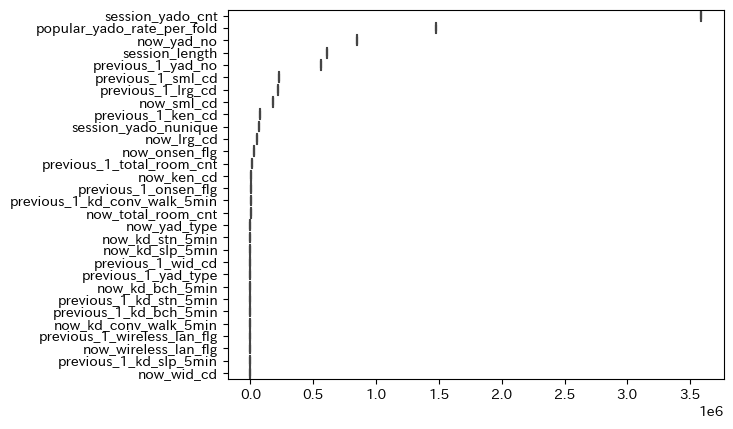

In [164]:
# 特徴量重要度を列にもつDataFrameを作成
feature_importances = [
    model.feature_importance(importance_type="gain") for model in models
]
feature_importances_df = pd.DataFrame(feature_importances, columns=use_col)

# 表示する順番を指定、特徴量重要度の平均が大きい順に並ぶよう計算
order = feature_importances_df.mean().sort_values(ascending=False).index.tolist()

# 表示
# fold毎の特徴量重要度のばらつきを見るために、箱ひげ図を利用
sns.boxplot(data=feature_importances_df, orient="h", order=order)

# Testに対する推論

In [165]:
# k 個のモデルの予測を作成. shape = (5, N_test,).
pred = np.array([model.predict(test[use_col]) for model in models])

# k 個のモデルの予測値の平均 shape = (N_test,).
pred = np.mean(pred, axis=0)  # axis=0 なので shape の `k` が潰れる

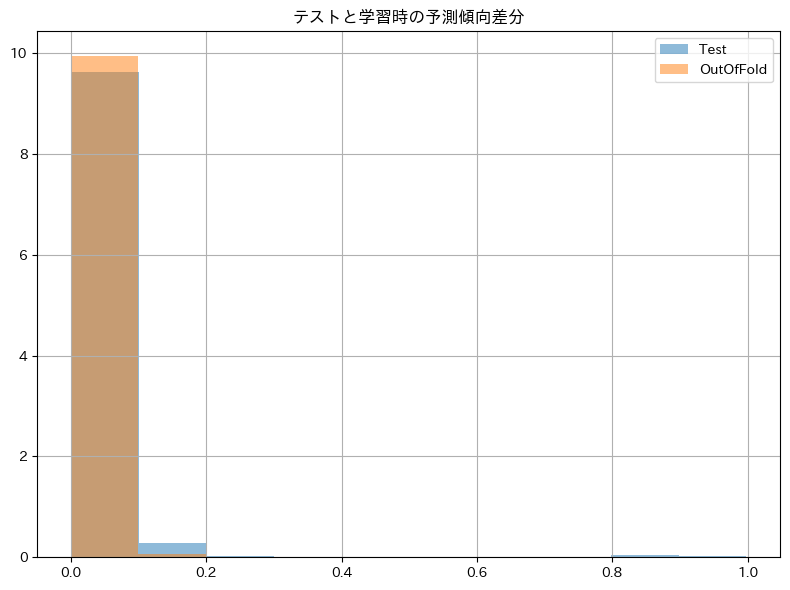

In [166]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = 0.02
# bins = np.linspace(0, 1, 0.1)
ax.hist(pred, density=True, alpha=0.5, label="Test")
ax.hist(oof, density=True, alpha=0.5, label="OutOfFold")
ax.grid()
ax.legend()
ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()

In [167]:
test["pred"] = pred

In [168]:
test

,session_id,yad_no,session_length,session_yado_nunique,session_yado_cnt,previous_1_yad_no,now_yad_no,now_yad_type,now_total_room_cnt,now_wireless_lan_flg,now_onsen_flg,now_kd_stn_5min,now_kd_bch_5min,now_kd_slp_5min,now_kd_conv_walk_5min,now_wid_cd,now_ken_cd,now_lrg_cd,now_sml_cd,previous_1_yad_type,previous_1_total_room_cnt,previous_1_wireless_lan_flg,previous_1_onsen_flg,previous_1_kd_stn_5min,previous_1_kd_bch_5min,previous_1_kd_slp_5min,previous_1_kd_conv_walk_5min,previous_1_wid_cd,previous_1_ken_cd,previous_1_lrg_cd,previous_1_sml_cd,popular_yado_rate_per_fold,pred
0,00001149e9c73985425197104712478c,109,2,2,0,1959,109.0,0.0,448.0,1.0,0.0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,2ffd60eb648dbbaa1d1ba33644813c44,0,173.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,0.000738,0.003330
1,00001149e9c73985425197104712478c,385,2,2,0,1959,385.0,0.0,2384.0,1.0,0.0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,2ffd60eb648dbbaa1d1ba33644813c44,0,173.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,0.001202,0.001053
2,00001149e9c73985425197104712478c,719,2,2,0,1959,719.0,0.0,600.0,1.0,0.0,1.0,NaN,NaN,1.0,f0112abf369fb03cdc5f5309300913da,072c85e1653e10c9c7dd065ad007125a,ed62e66a5031c23c78bd03ccf9f3ef70,d3d1cf557f10fadb1fbc0b429bf14578,0,173.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,0.001036,0.000236
3,00001149e9c73985425197104712478c,755,2,2,0,1959,755.0,0.0,912.0,1.0,0.0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,f2fcbd8e62872147efde0acef474e1f2,0,173.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,0.000883,0.002750
4,00001149e9c73985425197104712478c,1818,2,2,0,1959,1818.0,0.0,1039.0,1.0,0.0,1.0,NaN,NaN,1.0,f0112abf369fb03cdc5f5309300913da,072c85e1653e10c9c7dd065ad007125a,449c52ef581d5f9ef311189469a0520e,f76e14a3f2ebd4c7efd873fe9b5a02fd,0,173.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0,0.000991,0.001052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6337679,ffffe984aafd6127ce8e43e3ca40c79d,13017,1,1,0,8250,13017.0,0.0,853.0,1.0,0.0,1.0,NaN,NaN,1.0,f0112abf369fb03cdc5f5309300913da,072c85e1653e10c9c7dd065ad007125a,449c52ef581d5f9ef311189469a0520e,677a32689cd1ad74e867f1fbe43a3e1c,0,326.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,c9d5e891463e5389c42d16f987ed30bd,7cf2b4f31fb20747f89e58981e6d9fc1,0.001178,0.001028
6337680,ffffe984aafd6127ce8e43e3ca40c79d,13292,1,1,0,8250,13292.0,0.0,525.0,1.0,0.0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,2ffd60eb648dbbaa1d1ba33644813c44,0,326.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,c9d5e891463e5389c42d16f987ed30bd,7cf2b4f31fb20747f89e58981e6d9fc1,0.000883,0.001971
6337681,ffffe984aafd6127ce8e43e3ca40c79d,13468,1,1,0,8250,13468.0,0.0,1016.0,1.0,0.0,1.0,NaN,NaN,NaN,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,8a623b960557e87bd1f4edf71b6255be,1d9f09b9e2bd43cebc9885a46388739a,0,326.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,c9d5e891463e5389c42d16f987ed30bd,7cf2b4f31fb20747f89e58981e6d9fc1,0.000984,0.000191
6337682,ffffe984aafd6127ce8e43e3ca

In [169]:
test_session

,session_id,pred_yad_no_list,pred_yad_no_list_top10
0,00001149e9c73985425197104712478c,"[3560, 2305, 6766, 2040, 10965, 2911, 4714, 95...","[3560, 2305, 6766, 2040, 10965, 2911, 4714, 95..."
1,0000e02747d749a52b7736dfa751e258,"[8108, 613, 6129, 4066, 12862, 7014, 5267, 655...","[8108, 613, 6129, 4066, 12862, 7014, 5267, 655..."
2,0000f17ae2628237d78d3a38b009d3be,"[757, 3400, 7710, 10485, 410, 9190, 6721, 9910...","[757, 3400, 7710, 10485, 410, 9190, 6721, 9910..."
3,000174a6f7a569b84c5575760d2e9664,"[12341, 13521, 10746, 5080, 277, 1542, 7049, 1...","[12341, 13521, 10746, 5080, 277, 1542, 7049, 1..."
4,00017e2a527901c9c41b1acef525d016,"[4070, 6161, 6565, 3854, 3476, 5411, 5372, 286...","[4070, 6161, 6565, 3854, 3476, 5411, 5372, 286..."
...,...,...,...
174695,fffee3199ef94b92283239cd5e3534fa,"[1997, 9743, 11848, 10042, 2278, 9543, 10997, ...","[1997, 9743, 11848, 10042, 2278, 9543, 10997, ..."
174696,ffff62c6bb49bc9c0fbcf08494a4869c,"[2164, 3644, 9723, 13220, 448, 899, 13702, 380...","[2164, 3644, 9723, 13220, 448, 899, 13702, 380..."
174697,ffff9a7dcc892875c7a8b821fa436228,"[5810, 12939, 11796, 13241, 8143, 7308, 844, 8...","[5810, 12939, 11796, 13241, 8143, 7308, 844, 8..."
174698,ffffb1d30300fe17f661941fd085b04b,"[3096, 4976, 5079, 3002, 2510, 8501, 1530, 230...","[3096, 4976, 5079, 3002, 2510, 8501, 1530, 230..."


In [173]:
test[test["session_id"] == "0000e02747d749a52b7736dfa751e258"]

,session_id,yad_no,session_length,session_yado_nunique,session_yado_cnt,previous_1_yad_no,now_yad_no,now_yad_type,now_total_room_cnt,now_wireless_lan_flg,now_onsen_flg,now_kd_stn_5min,now_kd_bch_5min,now_kd_slp_5min,now_kd_conv_walk_5min,now_wid_cd,now_ken_cd,now_lrg_cd,now_sml_cd,previous_1_yad_type,previous_1_total_room_cnt,previous_1_wireless_lan_flg,previous_1_onsen_flg,previous_1_kd_stn_5min,previous_1_kd_bch_5min,previous_1_kd_slp_5min,previous_1_kd_conv_walk_5min,previous_1_wid_cd,previous_1_ken_cd,previous_1_lrg_cd,previous_1_sml_cd,popular_yado_rate_per_fold,pred
39,0000e02747d749a52b7736dfa751e258,143,1,1,0,11984,143.0,0.0,163.0,1.0,0.0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,2e63024b11908f3729510051a6fc7d9e,d075eb4a9669452b8f07cfc0d13a03ab,0,224.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,2e63024b11908f3729510051a6fc7d9e,d075eb4a9669452b8f07cfc0d13a03ab,0.000229,0.024430
40,0000e02747d749a52b7736dfa751e258,385,1,1,0,11984,385.0,0.0,2384.0,1.0,0.0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,2ffd60eb648dbbaa1d1ba33644813c44,0,224.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,2e63024b11908f3729510051a6fc7d9e,d075eb4a9669452b8f07cfc0d13a03ab,0.001202,0.002212
41,0000e02747d749a52b7736dfa751e258,532,1,1,0,11984,532.0,0.0,427.0,1.0,0.0,1.0,NaN,NaN,NaN,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,8a623b960557e87bd1f4edf71b6255be,1d9f09b9e2bd43cebc9885a46388739a,0,224.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,2e63024b11908f3729510051a6fc7d9e,d075eb4a9669452b8f07cfc0d13a03ab,0.000845,0.001335
42,0000e02747d749a52b7736dfa751e258,613,1,1,0,11984,613.0,0.0,69.0,1.0,0.0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,2e63024b11908f3729510051a6fc7d9e,d075eb4a9669452b8f07cfc0d13a03ab,0,224.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,2e63024b11908f3729510051a6fc7d9e,d075eb4a9669452b8f07cfc0d13a03ab,0.000100,0.107179
43,0000e02747d749a52b7736dfa751e258,719,1,1,0,11984,719.0,0.0,600.0,1.0,0.0,1.0,NaN,NaN,1.0,f0112abf369fb03cdc5f5309300913da,072c85e1653e10c9c7dd065ad007125a,ed62e66a5031c23c78bd03ccf9f3ef70,d3d1cf557f10fadb1fbc0b429bf14578,0,224.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,2e63024b11908f3729510051a6fc7d9e,d075eb4a9669452b8f07cfc0d13a03ab,0.001036,0.000718
44,0000e02747d749a52b7736dfa751e258,915,1,1,0,11984,915.0,0.0,428.0,1.0,0.0,NaN,NaN,NaN,NaN,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,8a623b960557e87bd1f4edf71b6255be,1d9f09b9e2bd43cebc9885a46388739a,0,224.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,2e63024b11908f3729510051a6fc7d9e,d075eb4a9669452b8f07cfc0d13a03ab,0.000838,0.001242
45,0000e02747d749a52b7736dfa751e258,1091,1,1,0,11984,1091.0,0.0,289.0,1.0,1.0,NaN,NaN,NaN,NaN,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,8a623b960557e87bd1f4edf71b6255be,1d9f09b9e2bd43cebc9885a46388739a,0,224.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,2e63024b11908f3729510051a6fc7d9e,d075eb4a9669452b8f07cfc0d13a03ab,0.000876,0.003187
46,0000e02747d749a52b7736dfa751e258,1266,1,1,0,11984,1266.0,0.0,33.0,1.0,0.0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,2e63024b11908f3729510051a6fc7d9e,d075eb4a9669452b8f07cfc0d13a03ab,0,224.0,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,2e63024b11908f3729510051a6fc7d9e,d075eb4a9669452b8f07cfc0d13a03ab,0.000173,0.062366
47,0000e02747d749a52b7736dfa751e258,1818,1,1,0,11984,1818.0,0.0,1039.0,1.0,0.0,1.0,NaN,NaN,1.0,f0112abf369fb03cdc5f5309300913da,072c85e1653e10c9c7dd065ad007125a,449c52ef581d5f9ef31118946

In [170]:
test_log[test_log["session_id"] == "ffff9a7dcc892875c7a8b821fa436228"]

,session_id,seq_no,yad_no
250302,ffff9a7dcc892875c7a8b821fa436228,0,8989


In [174]:
# TOP10に並び替え
# session_idごとにpredが高いyadoのlistを取得
pred_yad = (
    test.sort_values(["session_id", "pred"], ascending=False)
    .groupby("session_id")["yad_no"]
    .apply(list)
).to_dict()

test_session["pred_yad_no_list"] = test_session["session_id"].map(pred_yad)

# 上位10件に限定
test_session["pred_yad_no_list_top10"] = test_session["pred_yad_no_list"].apply(
    lambda x: x[:10]
)

# listをpd.Seriesに変換
pred_yad_df = test_session["pred_yad_no_list_top10"].apply(pd.Series)
pred_yad_df = pred_yad_df.rename(columns=lambda x: "predict_" + str(x))

print(pred_yad_df.isnull().sum())

# Nullの箇所はyad_no=10095(一番人気)で保管し、全ての値をintに変換する
# NOTE: 保管するのは本当に10095で良いのか考える
pred_yad_df = pred_yad_df.fillna(10095).astype(int)

predict_0    184
predict_1     51
predict_2      5
predict_3      1
predict_4     26
predict_5      0
predict_6      4
predict_7     66
predict_8     25
predict_9     72
dtype: int64


In [175]:
assert pred_yad_df.shape[0] == sample_submission.shape[0]
assert list(pred_yad_df.columns) == list(sample_submission.columns)

In [176]:
pred_yad_df.to_csv(
    f"../sub/{NOTEBOOK_NAME}_auc{oof_score:.4f}_mapk{oof_mapk_score:.4f}.csv",
    index=False,
)

In [177]:
f"../sub/{NOTEBOOK_NAME}_auc{oof_score:.4f}_mapk{oof_mapk_score:.4f}_dep_minus1.csv"

'../sub/e016_ch_data_to_pupular_base_auc0.9213_mapk0.5559_dep_minus1.csv'

In [ ]:
# TODO: 人気の情報を入れて、CVが改善しているのにtestのスコアが改善しないのはおかしいため、原因を調べる